In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch as ch
import numpy as np
import os
import torch.nn as nn
import argparse
import seaborn as sns
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from mib.models.utils import get_model
from mib.utils import get_models_path
from mib.dataset.utils import get_dataset
from mib.train import get_loader, train_model, evaluate_model
from sklearn.model_selection import train_test_split
from mib.attacks.theory_new import compute_hessian, fast_ihvp
from sklearn.linear_model import LogisticRegression

from torch_influence.modules import HVPModule, LiSSAInfluenceModule
from torch_influence.base import BaseObjective

In [3]:
def flatten_vec(vec):
    fvec = []
    for p in params_like:
        fvec.append(p.view(-1))
    return torch.cat(fvec)

In [4]:
target_model_index = 0

In [5]:
# Load model and take note of relevant data
model_arch = "mlp_mnistodd"
model, _, hparams = get_model(model_arch, 1)
base_dir = f"/p/distinf/mib_cache/models/mnistodd/{model_arch}/"
model_dict = ch.load(os.path.join(base_dir, f"{target_model_index}.pt"))
model.load_state_dict(model_dict["model"], strict=False)
model.eval()
model.cuda()

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [7]:
train_index = model_dict["train_index"]
test_index  = model_dict["test_index"]
N = len(train_index)

In [8]:
criterion = nn.BCEWithLogitsLoss()

class MyObjective(BaseObjective):
    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return criterion(outputs.squeeze(1), batch[1].float())

    def train_regularization(self, params):
        return 0

    def test_loss(self, model, params, batch):
        return criterion(model(batch[0]).squeeze(1), batch[1].float())  # no regularization in test loss

In [9]:
pkeep = 0.5
ds = get_dataset("mnistodd")()

train_data = ds.get_train_data()
test_data  = ds.get_test_data()

train_loader = get_loader(train_data, train_index, 512)
test_loader  = get_loader(test_data, test_index, 512)

/u/as9rw/work/auditing_mi/mib/dataset/mnist.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data.targets = ch.tensor(train_data.targets)
/u/as9rw/work/auditing_mi/mib/dataset/mnist.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data.targets = ch.tensor(test_data.targets)


In [10]:
def get_specific_grad(model, point_x, point_y, return_loss: bool = False):
    model.zero_grad()
    logits = model(point_x.cuda())
    loss = nn.BCEWithLogitsLoss()(logits, point_y.unsqueeze(0).float().cuda())
    if return_loss:
        ret_loss = loss.item()
    loss.backward()
    flat_grad = []
    for p in model.parameters():
        flat_grad.append(p.grad.detach().view(-1))
    flat_grad = ch.cat(flat_grad)
    model.zero_grad()
    if return_loss:
        return flat_grad, ret_loss
    return flat_grad

In [11]:
def collect_grad_on_all_data(model, loader):
    ctn = ch.nn.BCEWithLogitsLoss(reduction="sum")
    model.zero_grad()
    for x, y in loader:
        x, y = x.cuda(), y.cuda()
        loss = ctn(model(x).squeeze(), y.float())
        loss.backward()
    flat_grad = []
    for p in model.parameters():
        flat_grad.append(p.grad.detach().view(-1))
    flat_grad = ch.cat(flat_grad) / N
    model.zero_grad()
    return flat_grad

In [12]:
# Can collect 'all gradients' and then construct each n-1 setting from that
all_data_grad = collect_grad_on_all_data(model, train_loader)

In [13]:
exact_H = compute_hessian(model, train_loader, nn.BCEWithLogitsLoss(), device = "cuda")

In [15]:
exact_H_touse = exact_H.cpu().clone().detach()
# Compute SVD and add epsilon noise to non-zero eigenvalues
L, Q = ch.linalg.eigh(exact_H_touse)
eps = 1e-5
print(f"{ch.sum(1 * (L >= eps))} out of {L.shape[0]} eigenvalues are above {eps}!")
smart_choice_indices = (L > eps)
smart_Q = Q[smart_choice_indices]
smart_Q = (smart_Q.T[smart_choice_indices]).T
smart_H_inverse = smart_Q @ ch.diag(1 / L[smart_choice_indices]) @ smart_Q.T

L[smart_choice_indices] = eps
exact_H_touse = Q @ ch.diag(L) @ Q.T
# Compute inverse from here directly
H_inverse = Q @ ch.diag(1 / L) @ Q.T

3442 out of 6289 eigenvalues are above 1e-05!


In [16]:
grad = get_specific_grad(model, train_data[2][0], train_data[2][1])
actual_relevant_ihvp = (smart_H_inverse @ grad[smart_choice_indices].cpu()).cuda()

In [ ]:
# Compute ihvp with LiSSA
module = LiSSAInfluenceModule(
    model=model,
    objective=MyObjective(),
    train_loader=train_loader,
    test_loader=None,
    device="cuda",
    damp=0,
    repeat=20,
    depth=100, #5000 for MLP and Transformer, 10000 for CNN
    scale=100 # test in {10, 25, 50, 100, 150, 200, 250, 300, 400, 500} for convergence
)

In [ ]:
sims, diffs = [], []
for i in tqdm(range(10)):
    grad = get_specific_grad(model, train_data[i][0], train_data[i][1])
    actual_relevant_ihvp = (smart_H_inverse @ grad[smart_choice_indices].cpu()).cuda()
    ihvp = module.inverse_hvp(grad)
    ihvp_relevant = ihvp[smart_choice_indices]
    cosine_sim = nn.functional.cosine_similarity(ihvp_relevant.unsqueeze(0), actual_relevant_ihvp.unsqueeze(0)).item()
    normdiff = (ch.abs(ch.norm(ihvp_relevant) - ch.norm(actual_relevant_ihvp))).item()
    print(cosine_sim, normdiff)
    sims.append(cosine_sim)
    diffs.append(normdiff)

In [ ]:
print(np.mean(sims), "+/-", np.std(sims))
print(np.mean(diffs), "+/-", np.std(diffs))

In [ ]:
ihvp = module.inverse_hvp(grad)
ihvp_relevant = ihvp[smart_choice_indices]

In [ ]:
cosine_sim = nn.functional.cosine_similarity(ihvp_relevant.unsqueeze(0), actual_relevant_ihvp.unsqueeze(0)).item()
l2 = ch.norm(ihvp_relevant - actual_relevant_ihvp, 2).item()
normdiff = (ch.abs(ch.norm(ihvp_relevant) - ch.norm(actual_relevant_ihvp))).item()
print(cosine_sim, l2, normdiff)

- with 100 scale:
  - 0.7142822265625 +/- 0.05192919844409316
  - 11.936937987059355 +/- 17.92897013951449

- with 50 scale:
  - 0.6452893555164337 +/- 0.13971037275996379
  - 11.851892096363008 +/- 17.80627659719628
 
- with 10 repeats, 50 depth (instead of 20, 100):
  - 0.6861703723669053 +/- 0.07222075119409092
  - 11.920574374683202 +/- 17.905135836344748
 
- with 10 repeats, 100 depth:
  - 0.6689350426197052 +/- 0.09797662330058511
  - 11.896501280367374 +/- 17.870331110053517

- with 20 repeats, 50 depth:
  - 0.6867498099803925 +/- 0.06983868197260762
  - 11.920660879649223 +/- 17.90530133194961

- with 15 repeats, 75 depth:
  - 0.6755705744028091 +/- 0.08577207715673675
  - 11.908260511234403 +/- 17.8873053670706

In [ ]:
print(ch.norm(ch.diagonal(exact_H_touse @ H_inverse) - ch.ones(exact_H_touse.shape[0]), 2))
print(ch.norm((exact_H_touse @ H_inverse) - ch.eye(exact_H_touse.shape[0]), 2))

In [17]:
def specific_point_test(idx, smart: bool = False, train: bool = True):
    criterion = ch.nn.BCEWithLogitsLoss()
    if train:
        others_loader = get_loader(train_data, np.delete(train_index, idx), batch_size=512)
        point_x, point_y = train_data[idx]
    else:
        point_x, point_y = test_data[idx]
    
    grad, ret_loss = get_specific_grad(model, point_x, point_y, return_loss=True)

    if train:
        all_other_data_grad = (all_data_grad * len(train_index) - grad) / (len(train_data) - 1)
    else:
        all_other_data_grad = all_data_grad

    if smart:
        datapoint_ihvp = (smart_H_inverse @ grad[smart_choice_indices].cpu()).cuda()
        ihvp_alldata = (smart_H_inverse @ all_other_data_grad[smart_choice_indices].cpu()).cuda()
    else:
        datapoint_ihvp = (H_inverse @ grad.cpu()).cuda()
        # datapoint_ihvp = fast_ihvp(model, grad, others_loader, criterion, device="cuda")
        ihvp_alldata = (H_inverse @ all_other_data_grad.cpu()).cuda()
        # ihvp_alldata = fast_ihvp(model, all_other_data_grad, others_loader, criterion, device="cuda")
    
    #print(grad)
    #print(all_other_data_grad)
    #return 0, 0
    
    # Also compute self-influence score
    if smart:
        self_influence = ch.dot(grad[smart_choice_indices], datapoint_ihvp).cpu().item()
    else:
        self_influence = ch.dot(grad, datapoint_ihvp).cpu().item()
    
    I2 = ch.dot(datapoint_ihvp, datapoint_ihvp).cpu().item() / (2 * len(train_index))
    I3 = ch.dot(ihvp_alldata, datapoint_ihvp).cpu().item()
    return I2, I3, ret_loss, self_influence

In [18]:
I2s, I3s, losses, SIF = [], [], [], []
for i in tqdm(range(1000)):
    i2, i3, loss, sif = specific_point_test(train_index[i], smart=True)
    I2s.append(i2)
    I3s.append(i3)
    losses.append(loss)
    SIF.append(sif)

I2s = np.array(I2s)
I3s = np.array(I3s)
losses = np.array(losses)
SIF = np.array(SIF)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 278.78it/s]


In [19]:
I2s_test, I3s_test, losses_test, SIF_test = [], [], [], []
for i in tqdm(range(1000)):
    i2, i3, loss, sif = specific_point_test(i, smart=True, train = False)
    I2s_test.append(i2)
    I3s_test.append(i3)
    losses_test.append(loss)
    SIF_test.append(sif)

I2s_test = np.array(I2s_test)
I3s_test = np.array(I3s_test)
losses_test = np.array(losses_test)
SIF_test = np.array(SIF_test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 337.92it/s]


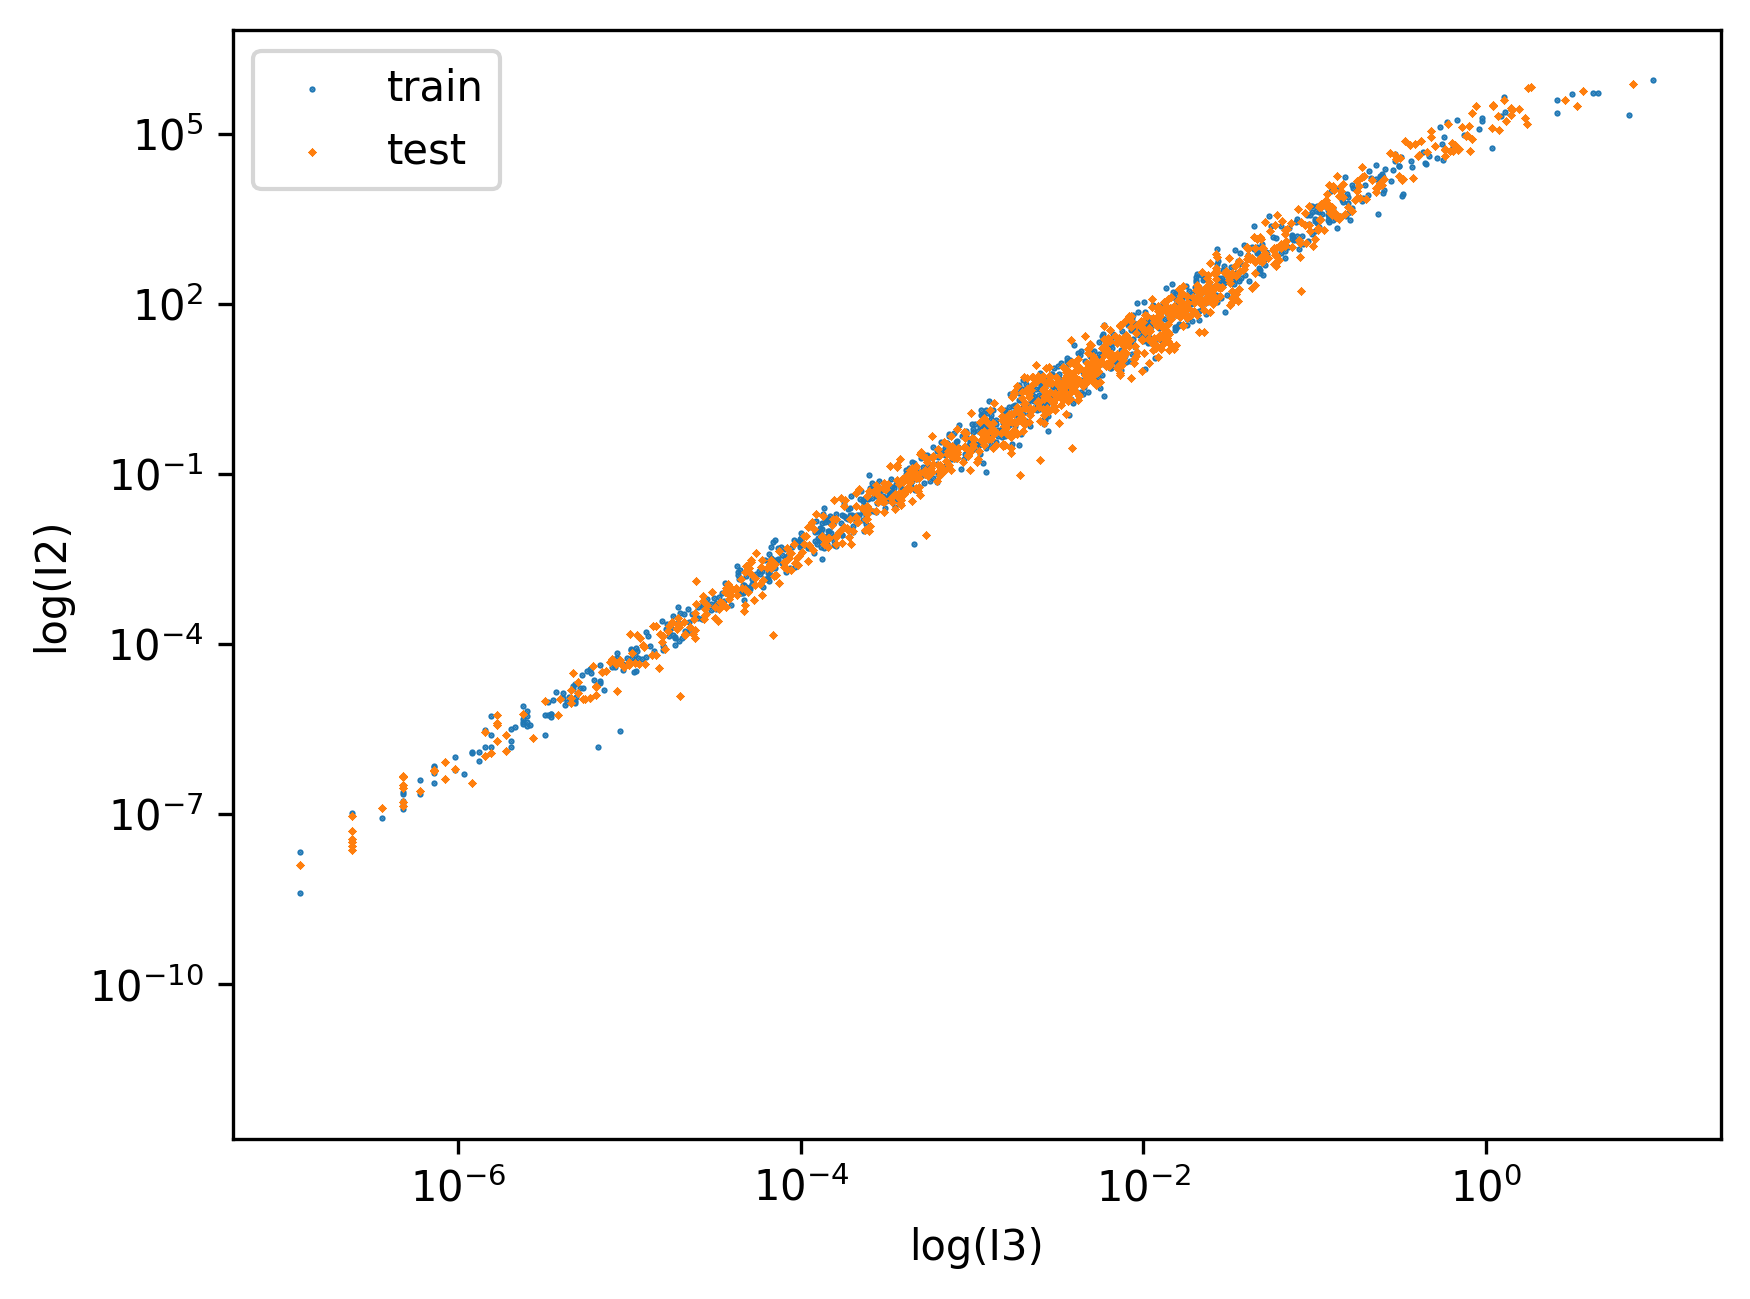

In [20]:
plt.scatter(losses, SIF, label="train", marker='.', s=1)
plt.scatter(losses_test, SIF_test, label="test", marker='x', s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("log(I3)")
plt.ylabel("log(I2)")
plt.legend()

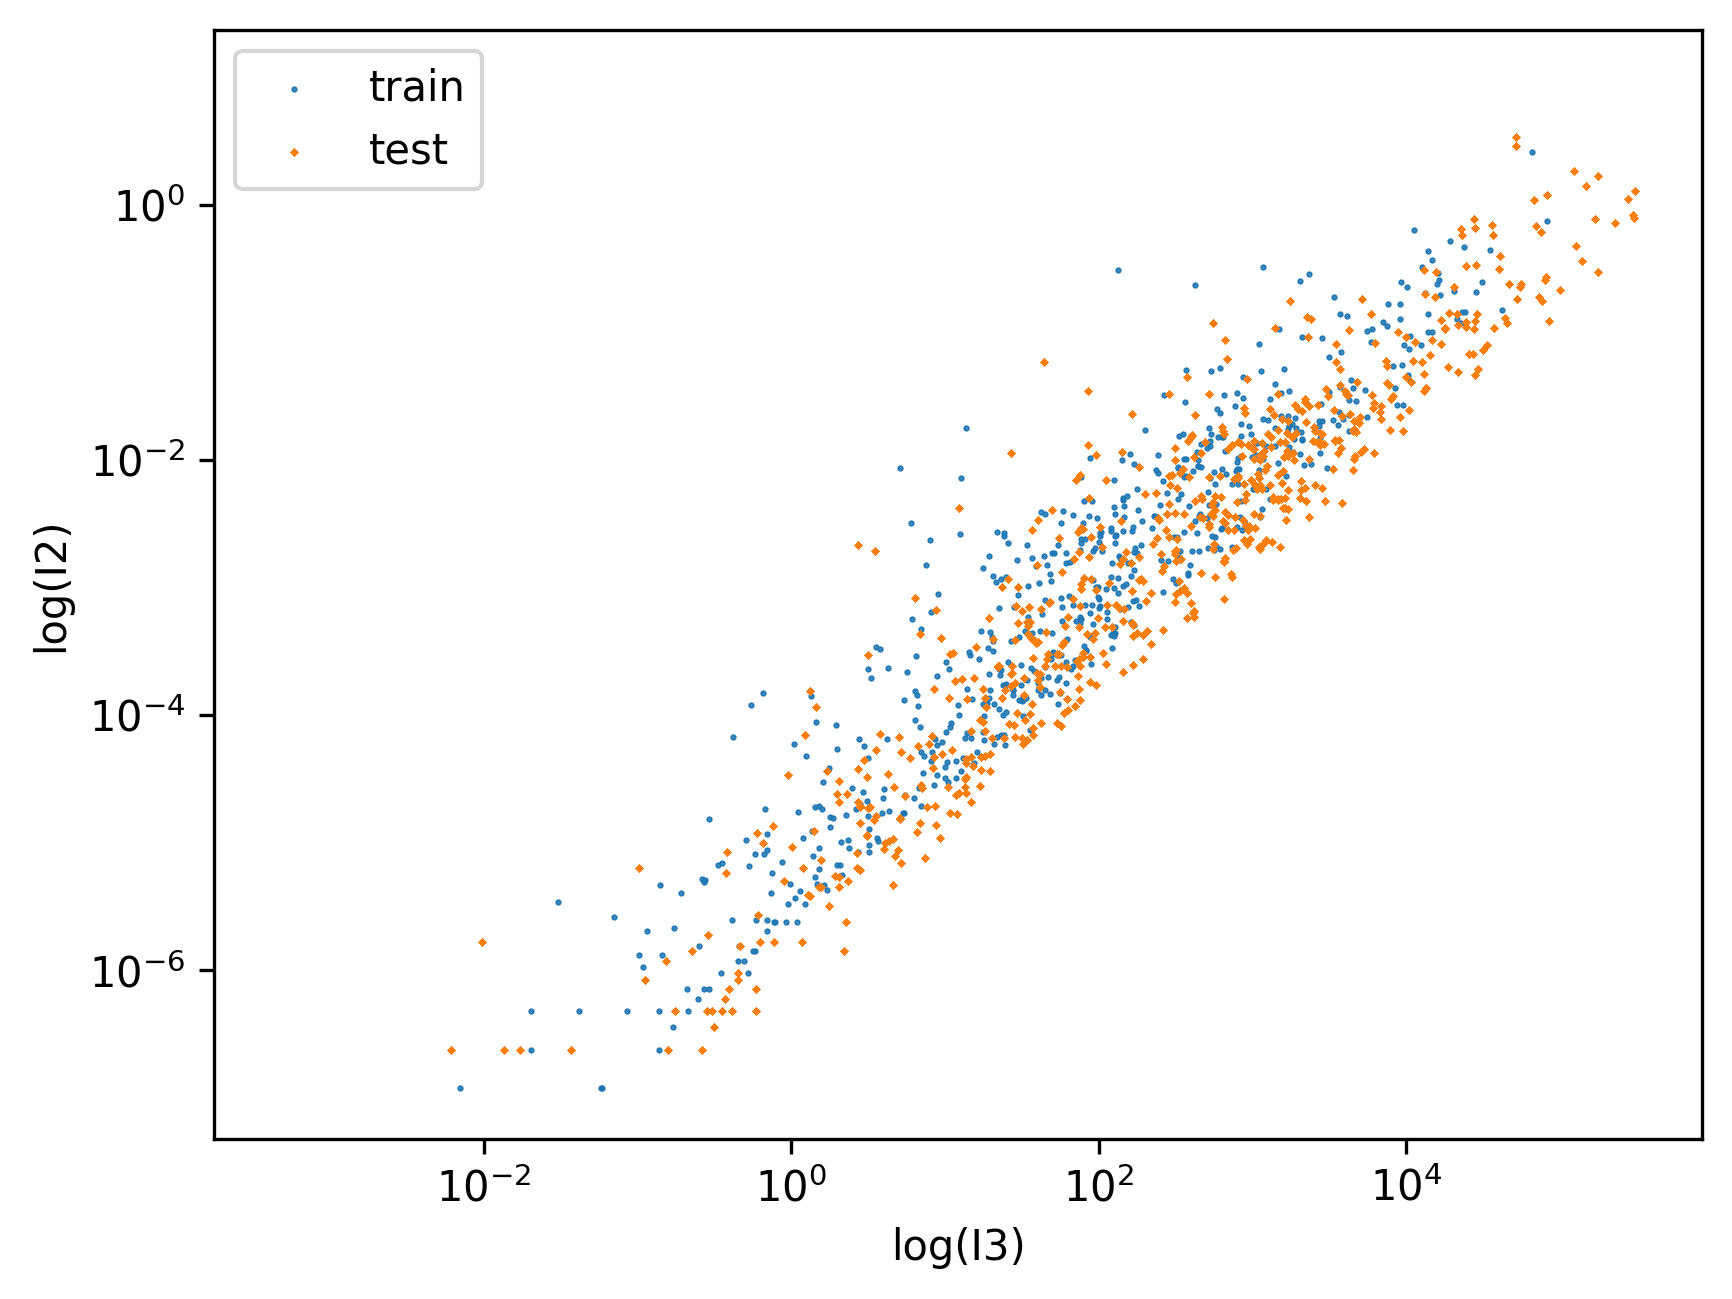

In [21]:
plt.scatter(I3s, losses, label="train", marker='.', s=1)
plt.scatter(I3s_test, losses_test, label="test", marker='x', s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("log(I3)")
plt.ylabel("log(I2)")
plt.legend()

In [ ]:
# combine them together, split into train-test and see how we do?
combined_1 = np.stack((I2s, I3s, losses), 1)
combined_0 = np.stack((I2s_test, I3s_test, losses_test), 1)
X = np.concatenate((combined_1, combined_0))
Y = np.concatenate((np.ones(len(combined_1)), np.zeros(len(combined_0))))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#nonnan = np.sum(np.isnan(X), 1) == 0
# print(nonnan.shape, X.shape)
X_notnan = np.log(X)
nonnan = np.sum(np.isnan(X), 1) == 0
X_notnan = X[nonnan]
X_train, X_test, y_train, y_test = train_test_split(X_notnan, Y, test_size=0.33, random_state=42)
combos = [(0, 1), (0, 2), (1, 2)]
for combo in combos:
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train[:, combo], y_train)
    print("Acc % 0.3f" %  clf.score(X_test[:, combo], y_test))
# Train linear classifier on (0, 1)
# Train linear classifier on (1, 1)

/tmp/ipykernel_451770/6760033.py:1: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(I2s), kde=True)


Text(0.5, 0, '$\\log(I_2)$')

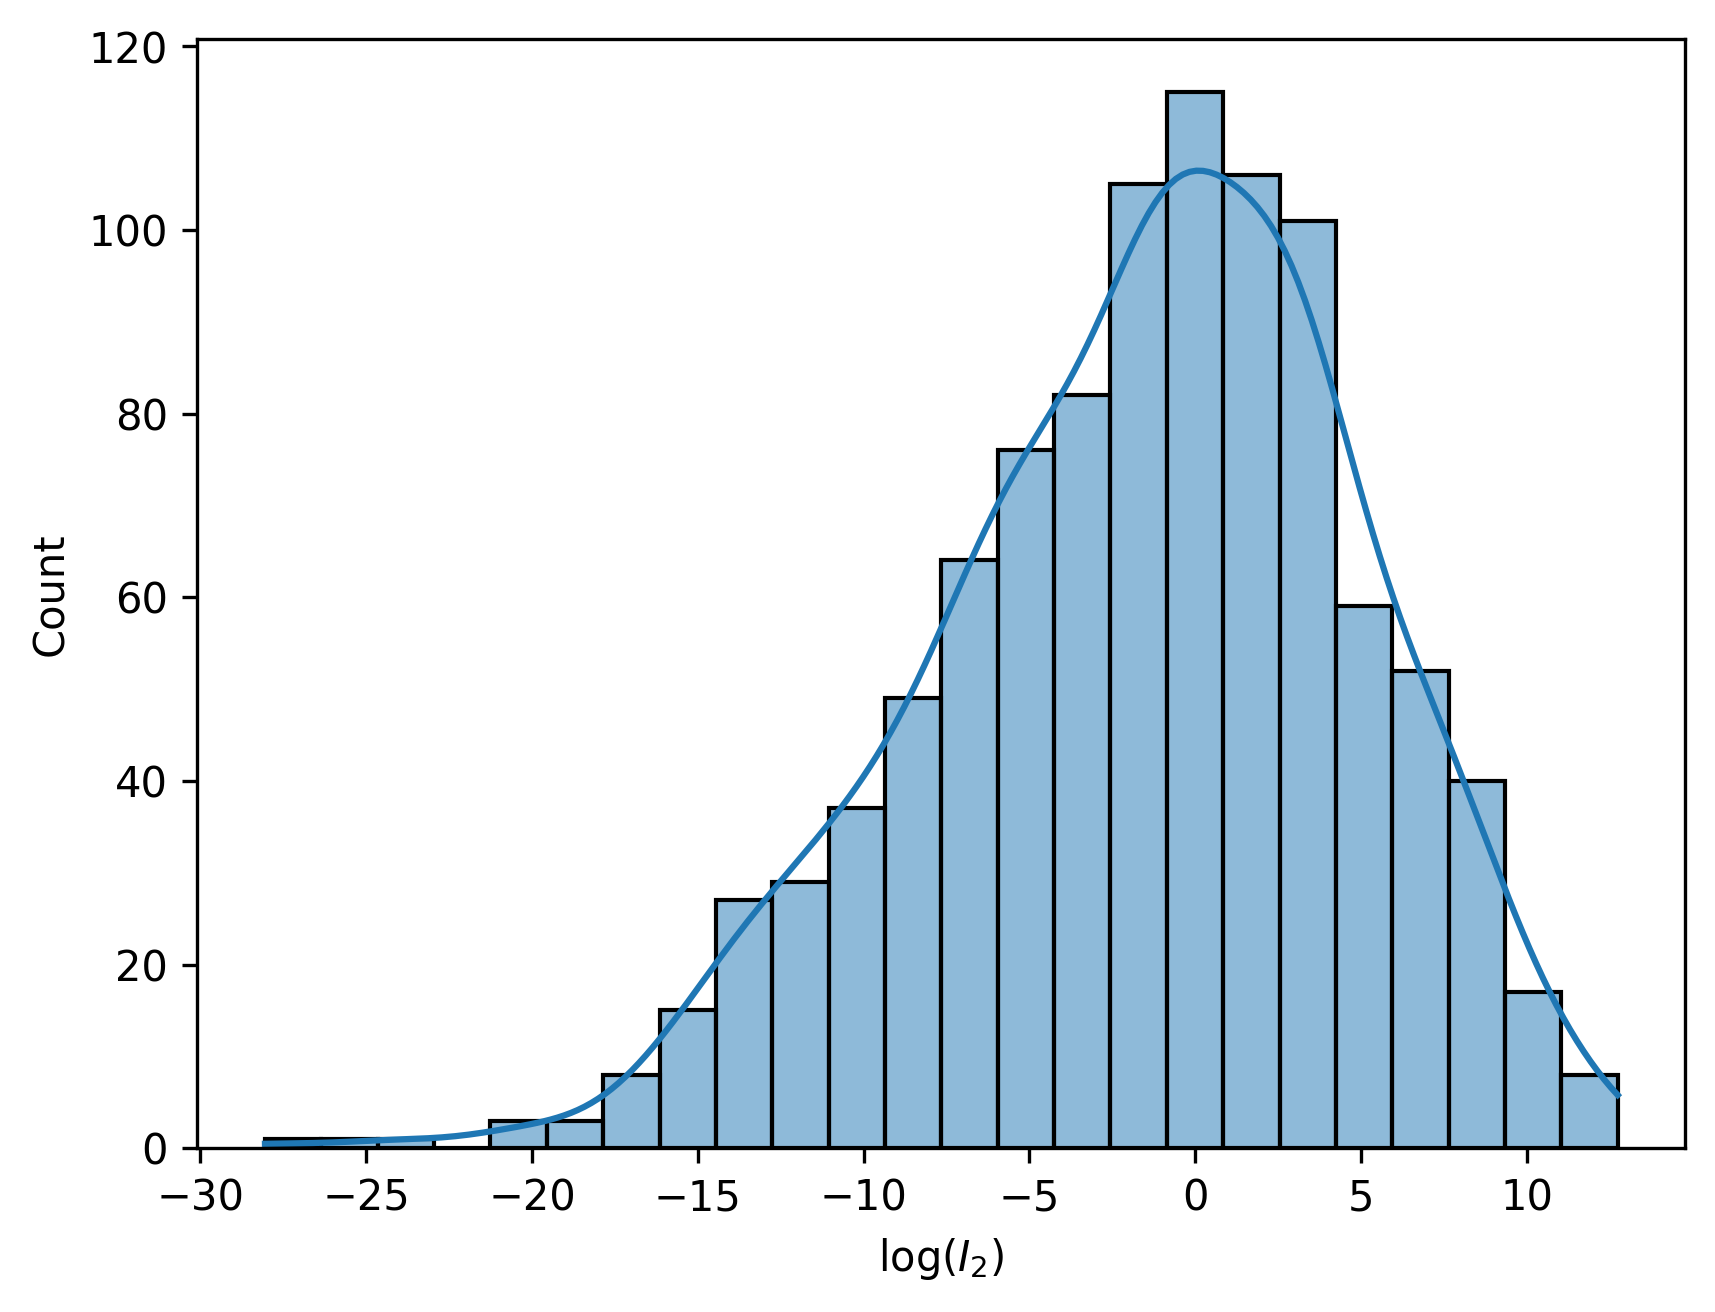

In [22]:
sns.histplot(np.log(I2s), kde=True)
plt.xlabel(r"$\log(I_2)$")

/tmp/ipykernel_451770/2476441171.py:1: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(I3s), kde=True, color='orange')
/tmp/ipykernel_451770/2476441171.py:1: RuntimeWarning: invalid value encountered in log
  sns.histplot(np.log(I3s), kde=True, color='orange')


Text(0.5, 0, '$\\log(I_3)$')

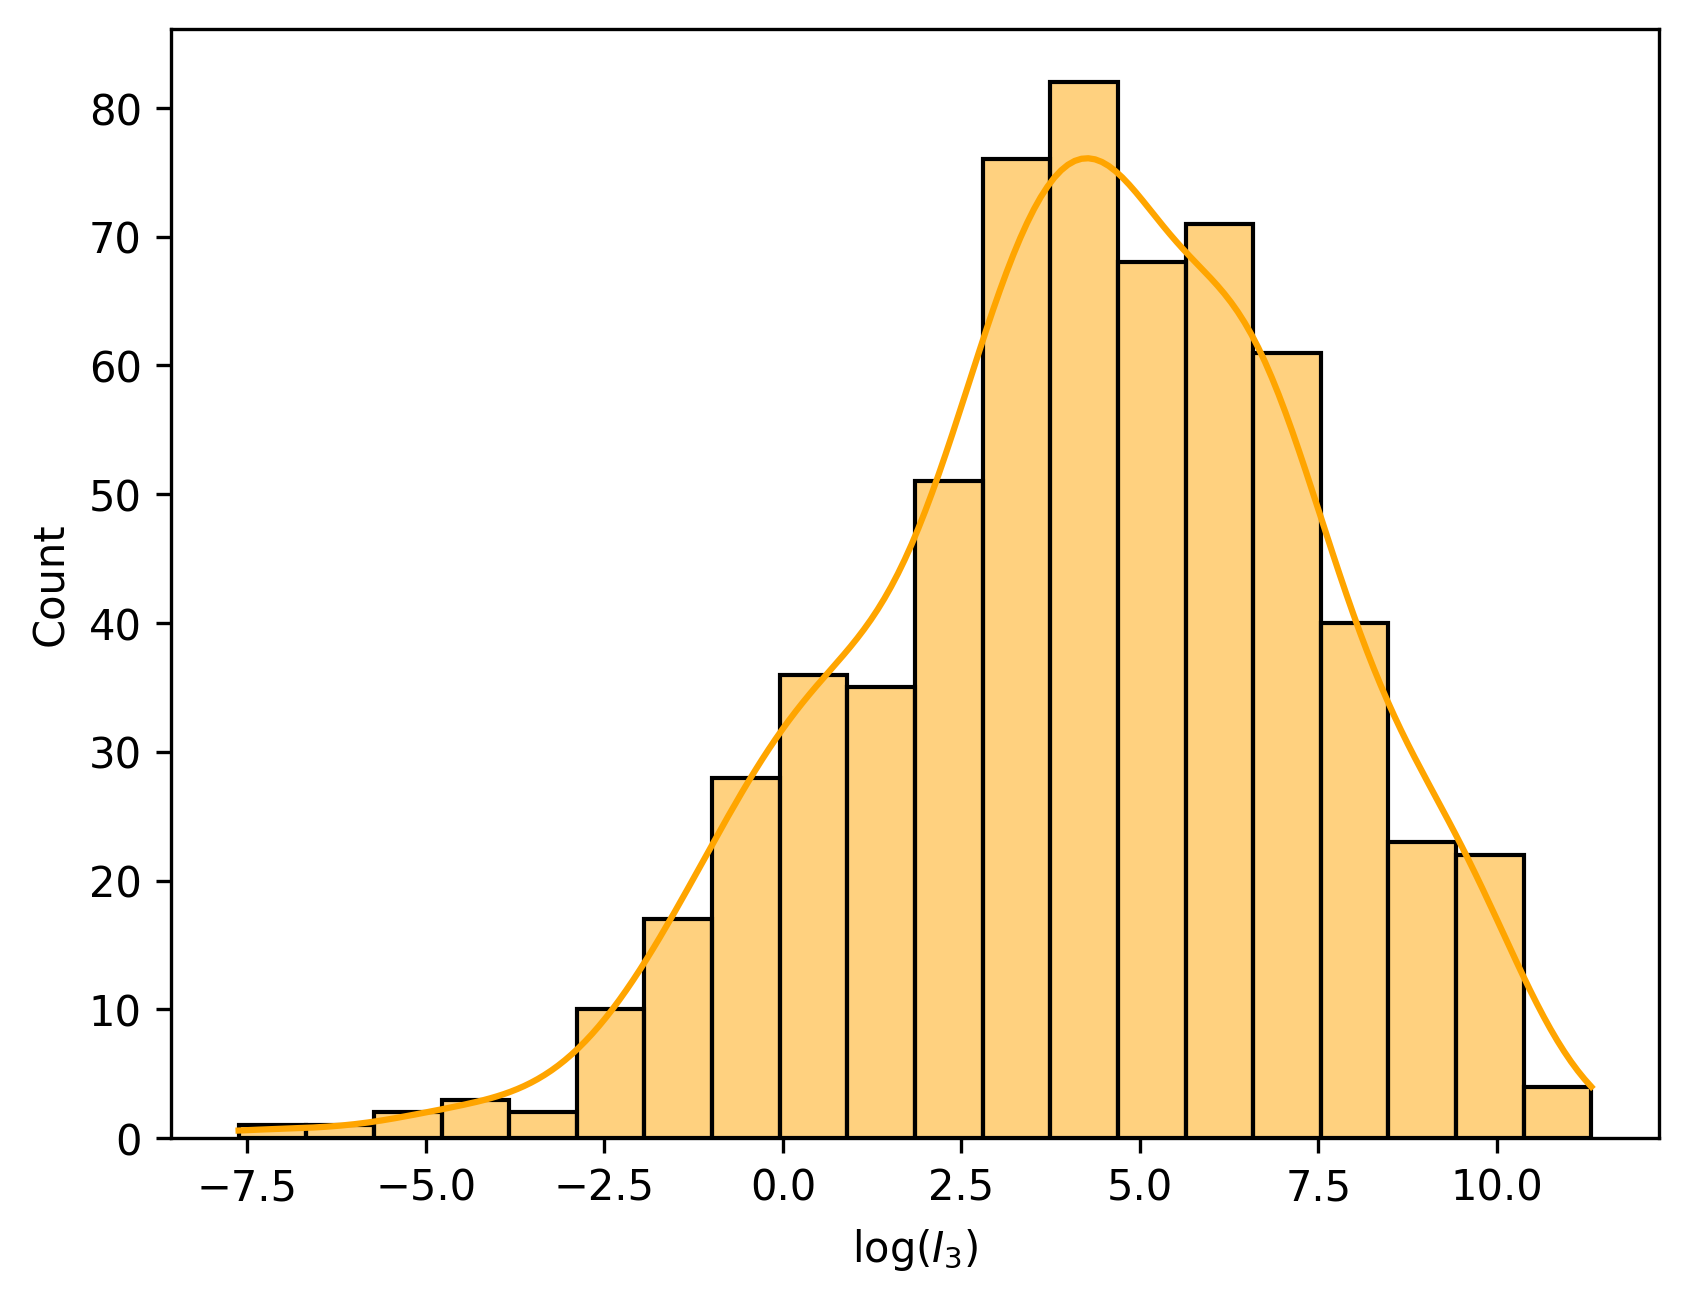

In [23]:
sns.histplot(np.log(I3s), kde=True, color='orange')
plt.xlabel(r"$\log(I_3)$")

In [ ]:
sns.histplot(np.log(SIF), kde=True)
sns.histplot(np.log(SIF_test), kde=True, color="orange")
plt.xlabel(r"$\log(loss)$")

/tmp/ipykernel_451770/1113375845.py:1: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(I2s), kde=True)


Text(0.5, 0, '$\\log(I_2)$')

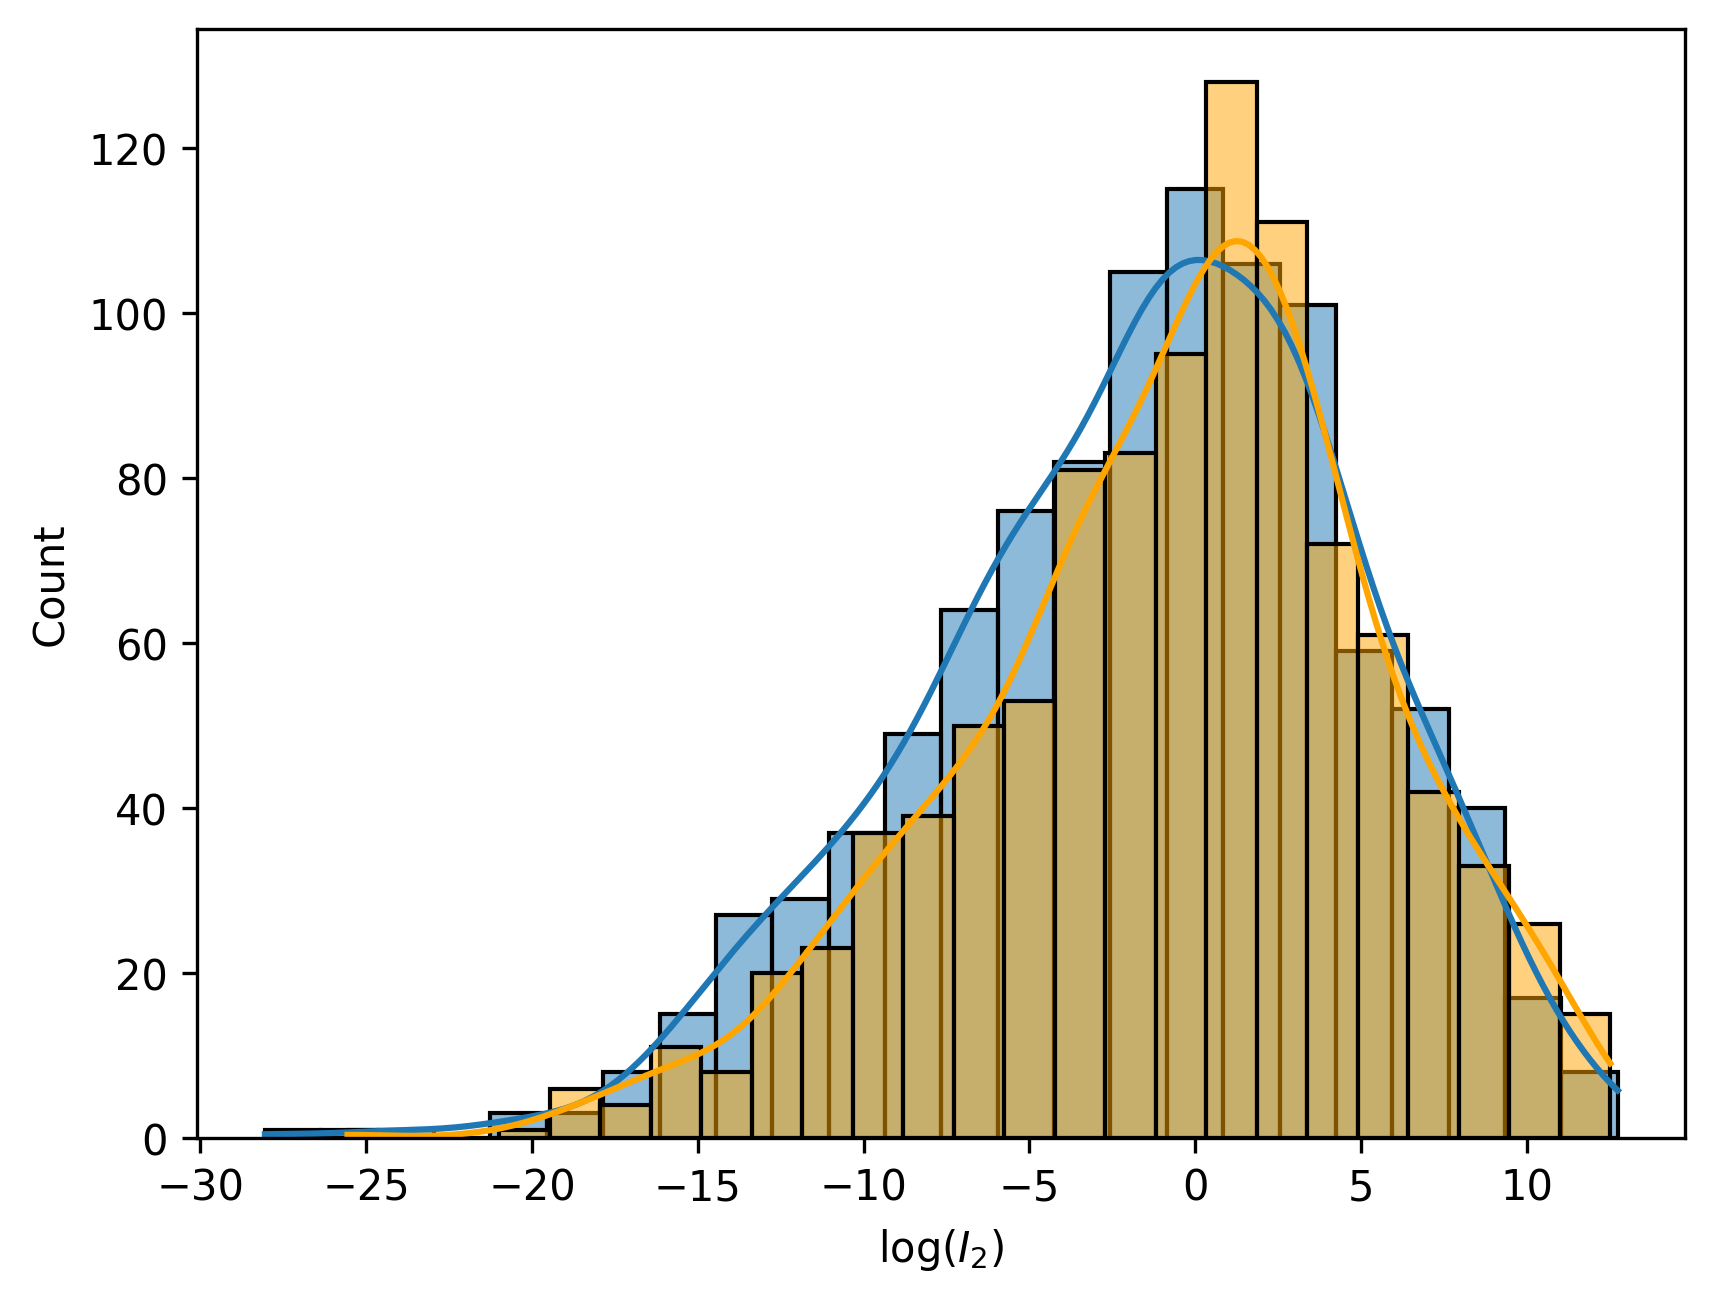

In [24]:
sns.histplot(np.log(I2s), kde=True)
sns.histplot(np.log(I2s_test), kde=True, color="orange")
plt.xlabel(r"$\log(I_2)$")

/tmp/ipykernel_451770/2787318515.py:1: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(I3s), kde=True)
/tmp/ipykernel_451770/2787318515.py:1: RuntimeWarning: invalid value encountered in log
  sns.histplot(np.log(I3s), kde=True)
/tmp/ipykernel_451770/2787318515.py:2: RuntimeWarning: invalid value encountered in log
  sns.histplot(np.log(I3s_test), kde=True, color="orange")


Text(0.5, 0, '$\\log(I_3)$')

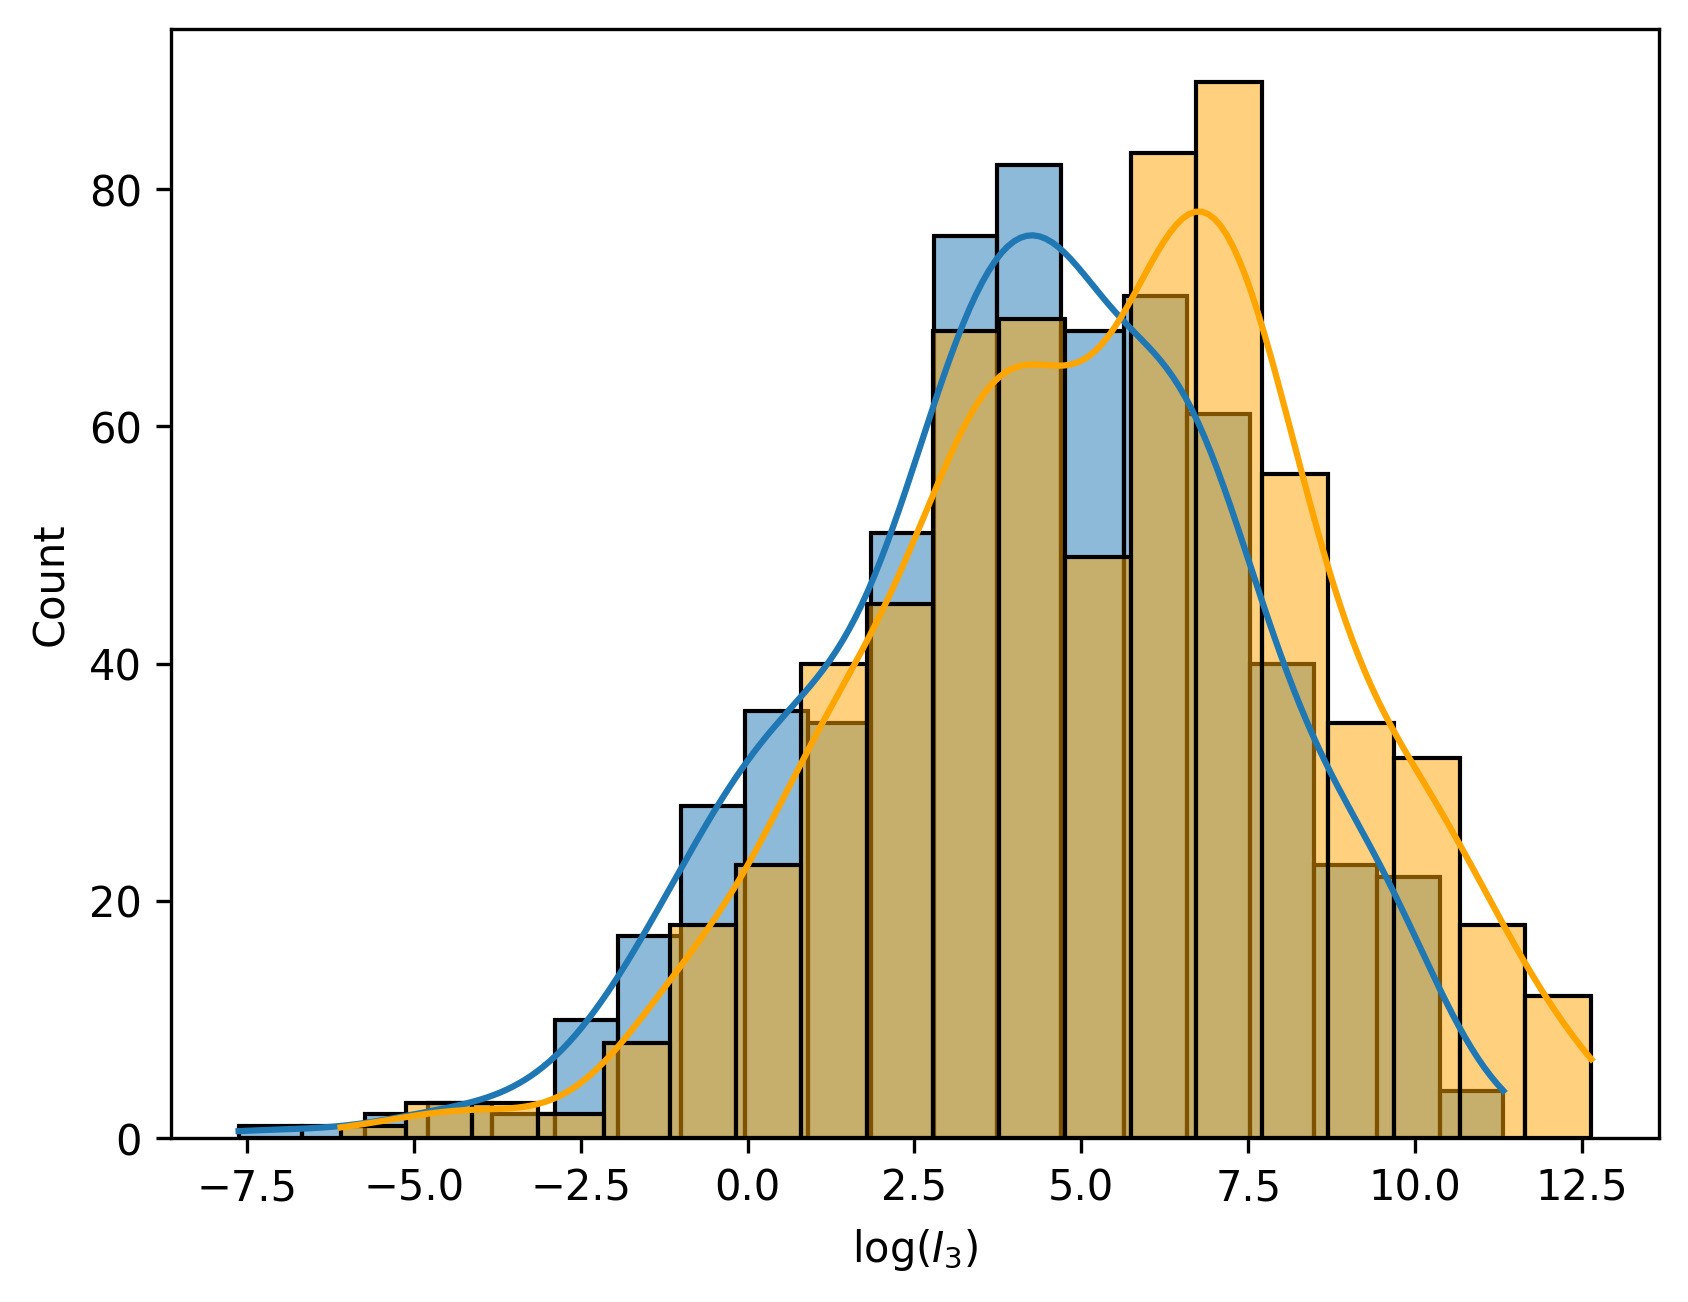

In [25]:
sns.histplot(np.log(I3s), kde=True)
sns.histplot(np.log(I3s_test), kde=True, color="orange")
plt.xlabel(r"$\log(I_3)$")

In [ ]:
sns.histplot(np.log(I3s) - np.log(I2s), kde=True)
sns.histplot(np.log(I3s_test) - np.log(I2s_test), kde=True, color="orange")
plt.xlabel(r"$\log(I_3)$")